In [1]:
# Importing necessary libraries
import os
import pickle
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
def preprocess_audio_files(directory, output_file):
    """
    Extract MFCC features from audio files in the specified directory 
    and save them to an output file.
    """
    min_length = float('inf')  # Initialize minimum length to a very high value



    # Find the minimum length among all MFCC features
    for i, folder in enumerate(filter(lambda f: f != ".DS_Store", os.listdir(directory)), start=1):
        if i == 11: break
        
        for file in os.listdir(os.path.join(directory, folder)):
            if file == ".DS_Store":
                continue

            # Read audio file and extract MFCC features
            rate, sig = wav.read(os.path.join(directory, folder, file))
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False, nfft=1024)

            # Update the minimum length of MFCC features
            min_length = min(min_length, mfcc_feat.shape[0])


    with open(output_file, 'wb') as f:  # Open file to write the MFCC features
        # Iterate over folders in the directory
        for i, folder in enumerate(filter(lambda f: f != ".DS_Store", os.listdir(directory)), start=1):
            if i == 11: break
            
            for file in os.listdir(os.path.join(directory, folder)):
                if file == ".DS_Store":
                    continue

                # Read audio file and extract MFCC features
                rate, sig = wav.read(os.path.join(directory, folder, file))
                mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False, nfft=1024)
                mfcc_feat_truncated = mfcc_feat[:min_length, :]
                # Save the MFCC features and corresponding folder label
                pickle.dump((mfcc_feat_truncated, i), f)


    

In [3]:
def compute_gwtau_distance(X_flat, Y_flat, n_features=13):
    """
    The distance function is the modified Gromov–Wasserstein distance introduced in the paper "Scalable
    Gromov–Wasserstein Based Comparison of Biological Time Series"
    available at https://link.springer.com/article/10.1007/s11538-023-01175-y
    The code is the Python version of the MATLAB script found in the authors' GitHub repo: https://github.com/kravtsova2/GWtau
    It is an optimal transport type distance for comparing time series trajectories.
    This script computes the GW distance between two flattened time series with a specified number of features.
    """
    # Reshape flattened arrays back to 2D for distance calculation
    X = X_flat.reshape(-1, n_features)
    Y = Y_flat.reshape(-1, n_features)

    # Calculate the L2 (Euclidean) norm of differences between consecutive points
    norm_vec_x = np.linalg.norm(np.diff(X, axis=0), ord=2, axis=1)
    norm_vec_y = np.linalg.norm(np.diff(Y, axis=0), ord=2, axis=1)

    # Compute cumulative sums of the normalized vectors
    v1, v2 = np.cumsum(norm_vec_x), np.cumsum(norm_vec_y)

    # Calculate the GWtau distance
    return np.linalg.norm(v1 - v2, ord=2) / np.sqrt(len(v1))


In [4]:
def load_dataset(filename):
    """
    Load the dataset from a file, trimming each MFCC feature sequence to the minimum length.
    """
    mfcc_data, genre_data = [], []

    with open(filename, 'rb') as f: 
        while True:  
            try:
                # Load the MFCC feature and corresponding genre
                mfcc_feat, genre = pickle.load(f)

                mfcc_data.append(mfcc_feat)
                genre_data.append(genre)

            except EOFError:  # Break the loop when EOF is reached
                break

    # Flatten the MFCC data and convert genre data to NumPy array
    return np.vstack([data.flatten() for data in mfcc_data]), np.array(genre_data)

In [5]:
# ## Use RandomizedSearchCV or GridSearchCV to do hyper parameter tuning

# def main():
#     # Directory containing the audio files and output file name
#     directory = "./Data/genres_original/"
#     output_file = "my_mfcc.dat"

#     # Preprocess the audio files to extract and save MFCC features
#     if not os.path.exists(output_file):
#         # If the file does not exist, preprocess the audio files to extract features
#         print("Preprocessing audio files and extracting features...")
#         preprocess_audio_files(directory, output_file)
#     else:
#     # If the file exists, skip preprocessing and use the existing file
#     print("Found existing processed file, loading data...")
    
#     # Load the dataset from the output file
#     mfcc_data_flat, genre_data = load_dataset(output_file)
    
#     # Define the parameters for grid search
#     # param_grid = {'n_neighbors': range(1,10), 'metric': [compute_gwtau_distance]}
    
#     # Define parameters for grid search
#     param_grid = {'n_neighbors': range(4,6),
#                   'metric': [compute_gwtau_distance]
#                   }
    
#     knn = KNeighborsClassifier()
#     grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

#     # Perform grid search to find the best KNN parameters
#     grid_search.fit(mfcc_data_flat, genre_data)
    
#     # Get the best parameters and model from the grid search
#     best_k = grid_search.best_params_['n_neighbors']
#     best_model = grid_search.best_estimator_

#     # Split the dataset into training and testing sets
#     train_X, test_X, train_y, test_y = train_test_split(mfcc_data_flat, genre_data, test_size=0.2, random_state=130)

#     # Train the best model on the training data
#     best_model.fit(train_X, train_y)

#     # Evaluate the model on the test data
#     accuracy = best_model.score(test_X, test_y)

#     # Print the results
#     print(f'Best K: {best_k}')
#     print(f'Test Accuracy: {accuracy}')
    


In [6]:
# Do not use RandomizedSearchCV or GridSearchCV

def main():
    # Directory containing the audio files and output file name
    directory = "./Data/genres_original/"
    output_file = "my_mfcc.dat"

    # preprocess_audio_files(directory, output_file)
    
    
    # Preprocess the audio files to extract and save MFCC features
    if not os.path.exists(output_file):
        # If the file does not exist, preprocess the audio files to extract features
        print("Preprocessing audio files and extracting features...")
        preprocess_audio_files(directory, output_file)
    else:
    # If the file exists, skip preprocessing and use the existing file
        print("Found existing processed file, loading data...")
    
    # Load the dataset from the output file
    mfcc_data_flat, genre_data = load_dataset(output_file)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        mfcc_data_flat, genre_data, test_size=0.2, random_state=130)
    print("Finish train-test split")
    neighbors = np.arange(1,7)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    for i, n_neighbors in enumerate(neighbors):
        knn = KNeighborsClassifier(
            n_neighbors=n_neighbors, metric=compute_gwtau_distance)    
        

        knn.fit(X_train, y_train)
        train_accuracy[i] = knn.score(X_train, y_train)
        print(f"train accuracy is {train_accuracy[i]} with {i+1} neighbors")
        test_accuracy[i] = knn.score(X_test, y_test)
        print(f"test accuracy is {test_accuracy[i]} with {i+1} neighbors")

    plt.plot(neighbors, test_accuracy, label = "Testing Dataset Accuracy ")
    plt.plot(neighbors, train_accuracy, label = "Training Dataset Accuracy")
    
    plt.legend()
    plt.xlabel("n_neighbors")
    plt.ylabel("Accuracy")
    plt.show()
    



Found existing processed file, loading data...
Finish train-test split
train accuracy is 1.0 with 1 neighbors
test accuracy is 0.25 with 1 neighbors
train accuracy is 0.545 with 2 neighbors
test accuracy is 0.225 with 2 neighbors
train accuracy is 0.475 with 3 neighbors
test accuracy is 0.255 with 3 neighbors
train accuracy is 0.45125 with 4 neighbors
test accuracy is 0.245 with 4 neighbors
train accuracy is 0.425 with 5 neighbors
test accuracy is 0.235 with 5 neighbors
train accuracy is 0.40625 with 6 neighbors
test accuracy is 0.22 with 6 neighbors


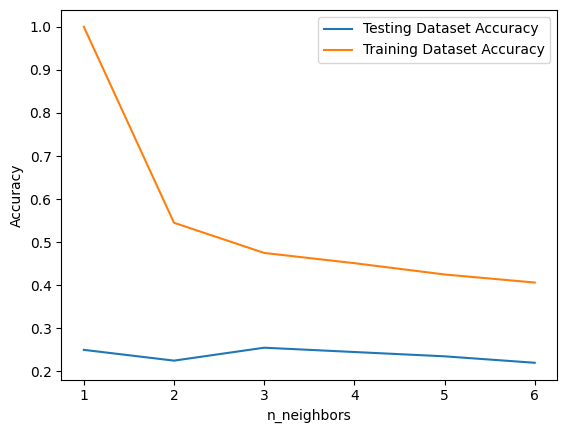

In [7]:
if __name__ == "__main__":
    main()


### Conclusion: The scalable Gromov–Wasserstein distance was introduced to compare biological time series. As shown above, it may not be suitable to classify musical genres using the time series of MFCC data.